In [1]:
%pylab inline
from astropy.cosmology import Planck13
from simqso.sqgrids import *
from simqso import sqbase
from simqso.sqrun import buildSpectraBulk,buildQsoSpectrum,save_spectra,load_spectra
from simqso.sqmodels import BOSS_DR9_PLEpivot,get_BossDr9_model_vars
random.seed(12345)
cosmo=Planck13

Populating the interactive namespace from numpy and matplotlib


In [2]:
# cover 1000A to 20um at R=1000
wave = sqbase.fixed_R_dispersion(1000,20e4,1000)

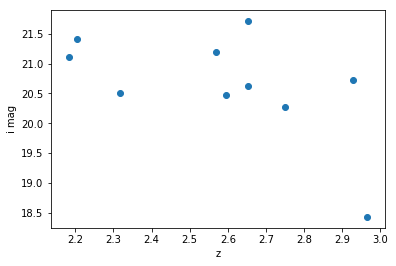

In [3]:
# just make up a few random redshifts between z=2 and z=3, then assign apparent mags according 
# to the BOSS DR9 QLF
nqso = 10
zin = 2.0 + np.random.rand(nqso)
kcorr = lambda z: sqbase.continuum_kcorr('SDSS-i',1450,z)
m2M = lambda z: sqbase.mag2lum('SDSS-i',1450,z,cosmo)
m,z = generateQlfPoints(BOSS_DR9_PLEpivot(cosmo=cosmo),
                        (17,22),(2.0,3.0),'SDSS-i',
                        kcorr=kcorr,zin=zin)
qsos = QsoSimPoints([m,z],cosmo=cosmo,units='flux')
# this initializes the absolute magnitudes using the simple continuum k-correction defined above.
# the "true" absolute magnitudes will be found later on.
qsos.addVar(AbsMagVar(FixedSampler(qsos.appMag-m2M(qsos.z))))
scatter(qsos.z,qsos.appMag)
xlabel('z')
ylabel('i mag')

In [4]:
# add the fiducial quasar SED model from BOSS DR9, don't add IGM absorption
sedVars = get_BossDr9_model_vars(qsos,wave,0,noforest=True)
qsos.addVars(sedVars)

In [5]:
# need to define photometry in SDSS system in order to calibrate apparent mags
qsos.loadPhotoMap([('SDSS','Legacy'),])

In [6]:
# ready to generate spectra. iteration is necessary to converge on the per-object k-correction,
# after two steps the maximum error on the absolute mags is <<1%
_,spectra = buildSpectraBulk(wave,qsos,saveSpectra=True,maxIter=3,verbose=10)

simulating  10  quasar spectra
units are  flux
buildSpectra iteration  1  out of  3
--> delta mag mean = -0.1314493, rms = 0.0821061, |max| = 0.2537216
buildSpectra iteration  2  out of  3
--> delta mag mean = -0.0013406, rms = 0.0012099, |max| = 0.0029567


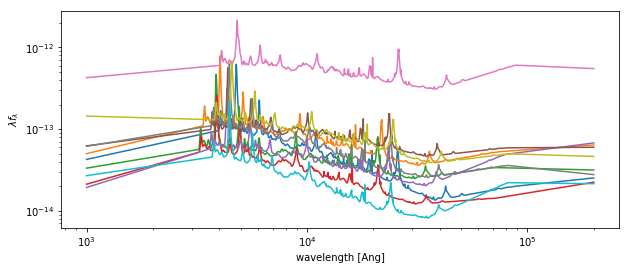

In [7]:
figure(figsize=(10,4))
plot(wave,(wave*spectra).transpose())
xscale('log')
yscale('log')
xlabel('wavelength [Ang]')
ylabel(r'$\lambda{f}_\lambda}$');

In [8]:
# the parameter values for each spectrum
qsos.data

appMag,z,absMag,slopes [5],"emLines [62,3]",synMag [5],synFlux [5]
float64,float64,float64,float64,float64,float64,float64
20.7202876032,2.92961609282,-24.5727793445,-1.58861642233 .. -1.2870212367,1033.07292218 .. 303.24260794,21.3312576428 .. 20.7489057708,2.93424884886 .. 5.01692595918
20.4980559658,2.31637555458,-24.215455655,-1.64409940229 .. -1.19208456779,1034.28048233 .. 268.960336091,20.9467669961 .. 20.263852144,4.18112548182 .. 7.8425833387
21.1166882372,2.18391881168,-23.3552144007,-1.44831382 .. -0.932824648661,1034.58339787 .. 327.033136504,21.362191131 .. 20.8674652481,2.85182943742 .. 4.49794251527
21.4155451341,2.20456027855,-23.2408260867,-1.76578967689 .. -1.43931570609,1033.20463835 .. 355.598097107,21.6488481969 .. 21.2353473033,2.19008374196 .. 3.20524387289
21.1940514642,2.56772502908,-23.797069617,-1.8438812642 .. -1.35015434714,1033.95229434 .. 310.273326778,21.7326535108 .. 20.9342446892,2.02739604835 .. 4.22962753148
20.4754414539,2.59554470298,-24.4423085326,-1.35328588615 .. -1.01809551637,1033.92017183 .. 266.72405819,21.1494674458 .. 20.1889044935,3.46906966791 .. 8.4030742806
18.4267605233,2.96451451974,-26.7400799166,-1.24793481208 .. -0.881804741132,1033.74487433 .. 299.601671168,19.2980364588 .. 18.3397513807,19.089098392 .. 46.1423222301
20.6294835478,2.65317709687,-24.4863993273,-1.44438442229 .. -0.710415428268,1033.20886476 .. 289.882115805,21.0527794509 .. 20.4819739131,3.79217368025 .. 6.41520346094
20.2775453687,2.74890663753,-24.7861530114,-0.920838176468 .. -0.91653782229,1034.38945522 .. 338.350717604,20.8924619433 .. 20.1533610312,4.3955702231 .. 8.68271582916


In [9]:
# save the spectra to a fits bin table
save_spectra(wave,spectra,'quickspeclib')

In [10]:
# restore the spectra
wave,spec = load_spectra('quickspeclib')